In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE


In [5]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 217.9 kB/s eta 0:11:29
   ---------------------------------------- 0.0/150.0 MB 388.9 kB/s eta 0:06:26
   ---------------------------------------- 0.1/150.0 MB 983.0 kB/s eta 0:02:33
   ---------------------------------------- 0.5/150.0 MB 3.1 MB/s eta 0:00:49
   ---------------------------------------- 0.9/150.0 MB 4.6 MB/s eta 0:00:33
   ---------------------------------------- 1.3/150.0 MB 5.6 MB/s eta 0:00:27
   ---------------------------------------- 1.8/150.0 MB 6.5 MB/s eta 0:00:23
    --------------------------------------- 2.2/150.0 MB 6.9 MB/s eta 0:00:22
    --------------------------------------- 2.6/150.0 MB 7.6 MB/s eta 0:00:20
    --------------------------------------- 3.0/150.0 MB 8.1 MB/s eta 0:00:19
    --------------------------------------- 3.5/150.0 MB 8.5 MB/s eta 0:

Class
0    284315
1       492
Name: count, dtype: int64


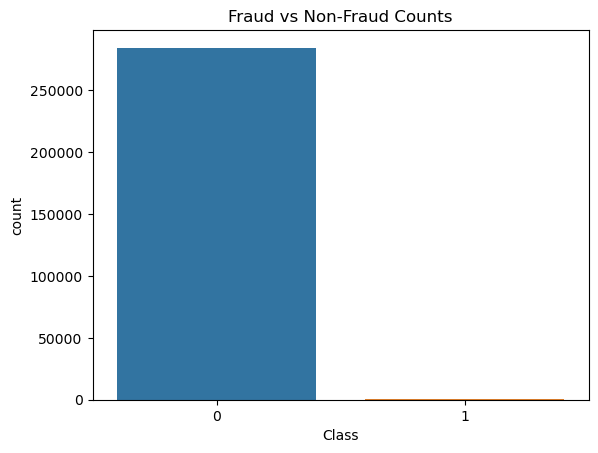

In [6]:
print(df["Class"].value_counts())

sns.countplot(x='Class', data=df)
plt.title('Fraud vs Non-Fraud Counts')
plt.show()


In [18]:
X = df.drop(['Class'], axis=1)
y = df['Class']


In [19]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Original:", y_train.value_counts())
print("Resampled:", pd.Series(y_train_res).value_counts())


Original: Class
0    227451
1       394
Name: count, dtype: int64
Resampled: Class
0    227451
1    227451
Name: count, dtype: int64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [21]:
model = XGBClassifier(
    scale_pos_weight=1,  # we balanced with SMOTE, so don't need extreme weights
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_res, y_train_res)


E:\ana\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:10:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9831145633548861


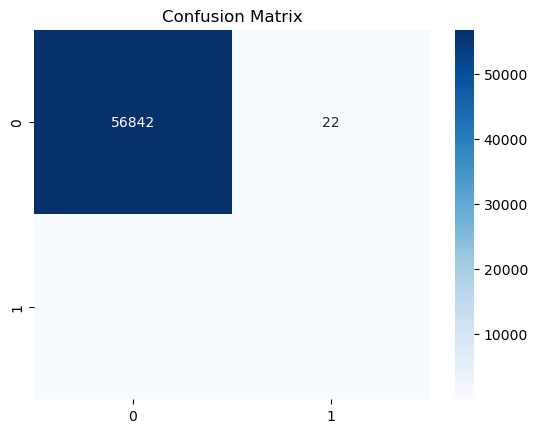

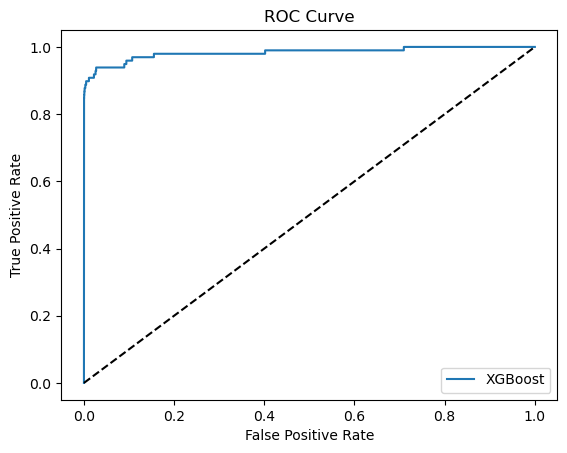

In [22]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [23]:
import joblib
joblib.dump(model, 'credit_card_fraud_xgb_model.pkl')


['credit_card_fraud_xgb_model.pkl']

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [25]:
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


ROC-AUC Score: 0.9831145633548861


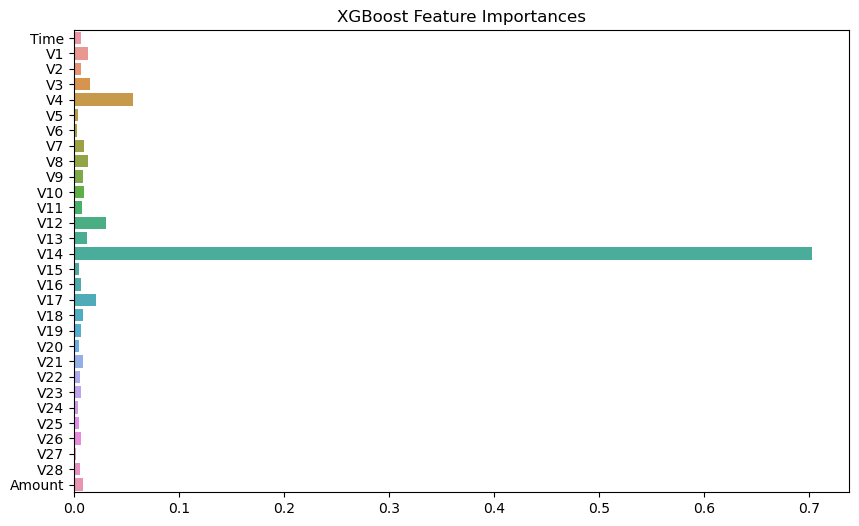

In [26]:
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('XGBoost Feature Importances')
plt.show()
